In [2]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# A basic example of reduced order quadrature

In [Antil _et al_ (2013)](https://arxiv.org/abs/1210.0577) the concept of _reduced order quadrature_ (ROQ) was introduced. The method has, in particular, found extensive use in the field of gravitational wave astronomy, following the initial work of [Canizares _et al_, 2013](https://ui.adsabs.harvard.edu/abs/2013PhRvD..87l4005C/abstract), where it is used to **massively speed-up the computation of likelihoods** during stochastic sampling (via, e.g., [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) or [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm)). In this note I will attempt to provide a brief, simple example of the "quadrature" part of this method and its use. For the "[reduced order](https://en.wikipedia.org/wiki/Model_order_reduction)" part I will not go into detail about the method of generating a set of [orthonormal basis vectors](https://en.wikipedia.org/wiki/Orthonormal_basis), but will make use of (and refer to) the [Arby](https://arby.readthedocs.io/en/latest/index.html) Python package.

## What's a "quadrature"?

Within reduced order quadrature, the "[quadrature](https://en.wikipedia.org/wiki/Quadrature_(mathematics))" term is just another way of saying numerical integration, i.e., calculating an integral by approximating it as a sum. E.g.,: 

$$
\int_a^b f(x) {\rm d}x \approx \sum_{i=1}^N f(x_i) \Delta x,
$$

where $f(x)$ is the integrand (the function to be integrated) integrated between the limits $a$ and $b$, $N$ is the number of intervals over which to split the sum and therefore $x_1 = a$ and $\Delta x = (b - a) / N$. More accurate numerical approximations such as the [trapezium rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) can be used.

In the papers above, and what we will assume in this example, is that the integrand is a very specific function: the natural logarithm of a [Gaussian likelihood](https://en.wikipedia.org/wiki/Normal_distribution) function:

$$
\ln{L(\vec{\theta})} = -\int_{-\infty}^{\infty} \frac{\left(d(t) - m(t;\vec{\theta})\right)^2}{2\sigma(t)^2} {\rm d}t,
$$

where $d(t)$ is some data as a function of $t$ (which might be, for example, _time_), $m(t;\vec{\theta})$ is a predictive model of some process as a function of $t$ and a set of parameters $\vec{\theta}$, and $\sigma(t)$ is an estimate of the noise standard deviation of the data as a function of $t$. In many statistical application, this is the form of the likelihood function you might want to use to, e.g., maximise and find the "best fit" model parameters $\vec{\theta}$, or sample from during the process of approximating a posterior probability distribution on the model parameters.

In realistic applications, the data $d$ is discrete rather than continuous, so the integral naturally becomes a sum with finite bounds (e.g., the start and end times of the data, or a lower and upper frequency range):

$$
\ln{L(\vec{\theta})} \propto \sum_{i=1}^{N} \frac{\left(d(t_i) - m(t_i;\vec{\theta})\right)^2}{\sigma(t_i)^2},
$$

where $N$ is the number of data points.

Reduced order quadrature is a way of speeding up the calculation of this sum by reducing the number point to sum over from $N$ to $M$, where $M \ll N$. This is particularly useful if the model $m$ is computationally expensive, i.e., it takes a long time to evaluate it for large numbers of data points, and/or $N$ is intrinsically large.

To get started on this path I will expand and separate out the terms in the above equation:

\begin{equation}
\ln{L(\vec{\theta})} \propto \left(\sum_{i=1}^{N} \frac{d_i^2}{\sigma_i^2}\right) + \left(\sum_{i=1}^{N} \frac{m_i(\vec{\theta})^2}{\sigma_i^2}\right) - \left(2 \sum_{i=1}^{N} \frac{d_i m_i(\vec{\theta})}{\sigma_i^2}\right),\
\label{eq:expanded}
\tag{1}
\end{equation}

where for compactness I've switched $m(t_i;\vec{\theta})$ to $m_i(\vec{\theta})$. In the subsequent equations I will switch $d_i/\sigma_i \rightarrow d_i$ and $m_i / \sigma_i \rightarrow m_i$, i.e., the data and model terms will be assumed to be already weighted by the noise.

The first term on the right hand side of the Equation $\eqref{eq:expanded}$ does not depend on the parameters $\vec{\theta}$, so no matter what $\vec{\theta}$ is used for the likelihood function it will always be the same. Therefore, $\mathcal{K} = \sum_{i=1}^N d_i^2$ only needs to be calculated once. The other terms must be calculated each time $\vec{\theta}$ changes. In some cases, e.g., that described in [Canizares _et al_, 2013](https://ui.adsabs.harvard.edu/abs/2013PhRvD..87l4005C/abstract), the second term involving the square of the model is analytic and therefore quick to calculate, but I'll not assume this here.


## How do you reduce the number of points?

Reducing the number of points over which you can sum relies on the model $m$ being reducible into a linear superposition of a relatively small number (compared to $N$) of (scaled) [orthonormal (i.e., orthogonal and normalised) basis vectors](https://en.wikipedia.org/wiki/Orthonormal_basis). This is known as [reduced order modelling](https://en.wikipedia.org/wiki/Model_order_reduction). Most generally the set of basic vectors must be "learned" by training in some way using models evaluated over the full prior range of the parameter space $\vec{\theta}$. This can be done with packages such as [Arby](https://arby.readthedocs.io/en/latest/index.html). After training, there should be a set of orthonormal asic vectors $b$ such that:

\begin{equation}
m(t; \vec{\theta}) \approx \sum_{j=1}^M C_j(\vec{\theta}) b_j(t)
\label{eq:basis}
\tag{2}
\end{equation}

where it is the coefficients $C$ that depend on the parameters $\vec{\theta}$, but not the basic vectors. Note that often the basis vectors are normalised such that

$$
\sum_{i=1}^N b_{ji} = 1.
$$

If we return to the third term in Equation $\eqref{eq:expanded}$ and substitute in Equation $\eqref{eq:basis}$ we get:

\begin{equation}
\sum_{i=1}^N d_i m_i(\vec{\theta}) \approx \sum_{i=1}^N d_i \left(  \sum_{j=1}^M C_j(\vec{\theta}) b_{ji} \right) \equiv \sum_{j=1}^M C_j(\vec{\theta}) \left(\sum_{i=1}^N d_i  b_{ji}\right),
\label{eq:rhs3}
\tag{3}
\end{equation}

where $b_{ji} = b_j(t_i)$.

> Note: we can see that the rearrangement of the summation terms works by expanding things for $N = M = 2$:
> $d_1 \left(C_1b_{11} + C_2b_{21}\right) + d_2\left(C_1b_{12} + C_2b_{22}\right) \equiv C_1\left(d_1b_{11} + d_2b_{12}\right) + C_2\left(d_1b_{21} + d_2b_{22} \right)$.

Neither the basis vectors $b$ nor the data depend on the parameters $\vec{\theta}$, so the sums over $N$ for each basis vector

$$
D_j = \sum_{i=1}^N d_i b_{ji}
$$

can all be pre-calculated. This means that Equation $\eqref{eq:rhs3}$ becomes a sum over $M$:

$$
\sum_{i=1}^N d_i m_i(\vec{\theta}) \approx \sum_{j=1}^M C_j(\vec{\theta}) D_j.
$$

Something similar can be done for the second term in Equation $\eqref{eq:expanded}$. However, we need a different set of basis vectors that have been calculated from the squared model, such that:

$$
m(t; \vec{\theta})^2 \approx \sum_{j=1}^{M'} C'_j(\vec{\theta}) b'_j(t),
$$

where $M'$ may be different from $M$.

So, in this case we have:

$$
\sum_{i=1}^N m_i(\vec{\theta})^2 \approx \sum_{i=1}^N \sum_{j=1}^{M'} C'_j(\vec{\theta}) b'_{ji} \equiv \sum_{j=1}^{M'} C'_j(\vec{\theta}) \sum_{i=1}^N b'_{ji}.
$$

Again, the sum over $N$ for the basis vectors does not involve $\vec{\theta}$, so these can be pre-computed:

$$
B_j = \sum_{i=1}^N {b'}_{ji}^2,
$$

and we get another sum just over $M'$:

$$
\sum_{i=1}^N m_i(\vec{\theta})^2 \approx \sum_{j=1}^{M'} C'_j(\vec{\theta}) B_j.
$$

Finally, Equation $\eqref{eq:expanded}$ can become:

\begin{equation}
\ln{L(\vec{\theta})} \propto \mathcal{K} + \sum_{j=1}^{M'} C'_j(\vec{\theta}) B_j - 2\sum_{j=1}^M C_j(\vec{\theta}) D_j.
\label{eq:roqlike}
\tag{4}
\end{equation}

So, provided $M \ll N$ and $M' \ll N$, there should be an approximately $N/\text{max}(M, M')$ speed-up in calculating Equation $\eqref{eq:roqlike}$ compared to $\eqref{eq:expanded}$.

## How do you calculate the $C$ coefficients?

To calculate the $C$ coefficients required for Equation $\eqref{eq:roqlike}$ you need to apply a bit of linear algebra. For a particular set of parameters $\vec{\theta}_k$ you need to evaluate the model $m(\vec{\theta}_k)$ at $M$ points (optimally chosing which points is beyond the scope of this note). Say we had only 2 basis vectors, i.e., $M=2$, then we can define the two simultaneous equations:

$$
\begin{eqnarray}
m(t_l;\vec{\theta}_k) & = & \sum_{j=1}^2 C_j(\vec{\theta}_k) b_{jl} \equiv C_1(\vec{\theta}_k) b_{1l} + C_2(\vec{\theta}_k) b_{2l}, \\
m(t_n;\vec{\theta}_k) & = & \sum_{j=1}^2 C_j(\vec{\theta}_k) b_{jn} \equiv C_1(\vec{\theta}_k) b_{1n} + C_2(\vec{\theta}_k) b_{2n},
\end{eqnarray}
$$

which in matrix notation becomes:

$$
\left( \begin{array}{c} m_l(\vec{\theta}_k) \\ m_n(\vec{\theta}_k) \end{array} \right) = \left( \begin{array}{c} C_1(\vec{\theta}_k) \\ C_2(\vec{\theta}_k) \end{array} \right) \left( \begin{array}{cc} b_{1l} & b_{2l} \\ b_{1n} & b_{2n} \end{array} \right) 
$$

where the values of $m_l(\vec{\theta}_k)$ and $m_n(\vec{\theta}_k)$ can be explicitly calculated from the model at the points $t_l$ and $t_n$. The basis vector matrix:

$$
\mathsf{B} = \left( \begin{array}{cc} b_{1l} & b_{2l} \\ b_{1n} & b_{2n} \end{array} \right),
$$

can then be inverted to solve the equations for $C_1(\vec{\theta}_k)$ and $C_2(\vec{\theta}_k)$:

$$
\left( \begin{array}{c} C_1(\vec{\theta}_k) \\ C_2(\vec{\theta}_k) \end{array} \right) = \left( \begin{array}{c} m_l(\vec{\theta}_k) \\ m_n(\vec{\theta}_k) \end{array} \right) \cdot  \mathsf{B}^{-1},
$$

where:

$$
\mathsf{B}^{-1} = \frac{1}{|\mathsf{B}|} \left( \begin{array}{cc} b_{2n} & -b_{2l} \\ -b_{1n} & b_{1l} \end{array} \right),
$$

and the determinant $|B| = b_{1l}b_{2n} - b_{1n}b_{2l}$. So, for this two-basis-vector case we would have:

$$
\begin{eqnarray}
C_1(\vec{\theta}_k) & = \frac{m_l(\vec{\theta}_k) b_{2n} - m_n(\vec{\theta}_k) b_{2l}}{b_{1l}b_{2n} - b_{1n}b_{2l}} \\
C_2(\vec{\theta}_k) & = \frac{-m_l(\vec{\theta}_k) b_{1n} + m_n(\vec{\theta}_k) b_{1l}}{b_{1l}b_{2n} - b_{1n}b_{2l}}.
\end{eqnarray}
$$

The same thing can be done for calculating the $C'$ coefficients, instead using the square of the model and the $b'$ basic vectors.

# A simple example

Here I will provide a simple example where the model is explicitly defined in a way that I already know the basis functions. As stated above, more generally you would need to determine the basis vectors through a process such as reduced order modelling.

The simple example is explicitly defined to be the sum of two simple functions:

$$
f(t; A, \phi_0, m, c) = g(t; A, \phi_0) + h(t; m, c),
$$

where I will set $g(t)$ to be the sine function with a fixed angular frequency but unknown amplitude $A$ and initial phase \phi_0:

$$
g(t; A, \phi_0) = A sin(2.3 t + \phi_0),
$$

and $h(t)$ to be the function for a straight line with an unknown gradient $m$ and $y$-intercept $c$:

$$
h(t; m, c) = m t + c.
$$

These equations can be broken down into four simple basis functions (the basis _vectors_ mentioned earlier are just these functions evaluated at a set of point in $t$):

$$
\begin{eqnarray}
b_1(t) &= \sin{(2.3 t)}, \\
b_2(t) &= \cos{(2.3 t)}, \\
b_3(t) &= t, \\
b_4(t) &= 1,
\end{eqnarray}
$$

such that:

$$
f(t; A, \phi_0, m, c) = C_1 b_1 + C_2 b_2 + C_3 b_3 + C_4 b_4.
$$

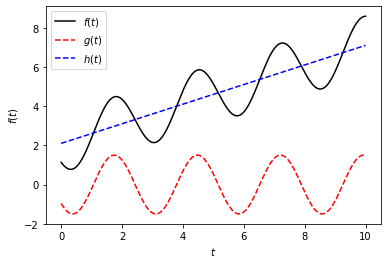

In [45]:
def g(t, A, phi0):
    return A * np.sin(2.3 * t + phi0)

def h(t, m, c):
    return m * t + c

def f(t, A, phi0, m, c):
    return g(t, A, phi0) + h(t, m, c)

# plot an example of the function
A = -1.5
phi0 = 0.7
m = 0.5
c = 2.1

N = 1000  # number of points to evaluate the function
t = np.linspace(0, 10, N)

fig, ax = plt.subplots()
ax.plot(t, f(t, A, phi0, m, c), "k-", label="$f(t)$")
ax.plot(t, g(t, A, phi0), "r--", label="$g(t)$")
ax.plot(t, h(t, m, c), "b--", label="$h(t)$")
ax.legend()
ax.set_xlabel("$t$");
ax.set_ylabel("$f(t)$");

For a particular set of parameters $\vec{\theta}_k = \{A_k, {\phi_0}_{k}, m_k, c_k\}$ the coefficients $C$ can be calculated by evaluating the basic vectors at four points. I will just chose four points evenly spaced in $t$, assuming there are $N$ points in $t$, so $t'_1 = t_1$, $t'_2 = t_{N/4}$, $t'_3 = t_{N/2}$ and $t'_4 = t_{3N/4}$, and solving:

$$
\left(\begin{array}{c} C_1 \\ C_2 \\ C_3 \\ C_4 \end{array}\right) =  \left(\begin{array}{c} f(t_1; A_k, {\phi_0}_k, m_k, c_k) \\ f(t_2; A_k, {\phi_0}_k, m_k, c_k) \\ f(t_3; A_k, {\phi_0}_k, m_k, c_k) \\ f(t_4; A_k, {\phi_0}_k, m_k, c_k)\end{array}\right) \cdot \mathsf{B}^{-1},
$$

where

$$
\mathsf{B} = \left(\begin{array}{cccc} b_1(t_1) & b_1(t_2) & b_1(t_3) & b_1(t_4) \\  b_2(t_1) & b_2(t_2) & b_2(t_3) & b_2(t_4) \\  b_3(t_1) & b_3(t_2) & b_3(t_3) & b_3(t_4) \\  b_4(t_1) & b_4(t_2) & b_4(t_3) & b_4(t_4) \end{array}\right).
$$

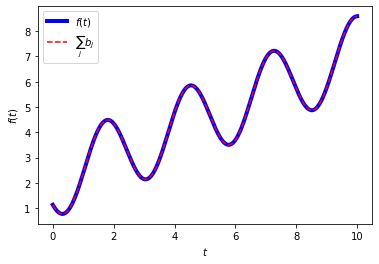

In [18]:
# define the basis vectors
def b1(t):
    return np.sin(2.3 * t)

def b2(t):
    return np.cos(2.3 * t)

def b3(t):
    return t

def b4(t):
    return np.ones_like(t)

# get array of basis vectors over t
Bfull = [b(t) for b in [b1, b2, b3, b4]]

# get indices for 4 tprime values
indices = slice(0, -1, int(N/4) + 1)

# get the B matrix
B = np.array([row[indices] for row in Bfull])

# evaluate f at tprime values
F = f(t[indices], A, phi0, m, c)

# solve for C
C = np.dot(F, np.linalg.inv(B))
#C = np.einsum("i,ij->j", F, np.linalg.inv(B))

# plot original function versus sum of basis vectors
fig, ax = plt.subplots()
ax.plot(t, f(t, A, phi0, m, c), "b-", label="$f(t)$", lw=4)
ax.plot(t, np.sum([C[i] * Bfull[i] for i in range(4)], axis=0), "r--", label="$\sum_j b_j$")
ax.legend()
ax.set_xlabel("$t$");
ax.set_ylabel("$f(t)$");

In the above plot it can be seen that the original function can be reconstructed from the basis vectors.

But, now I'll look at evaluating the natural logarithm for the Gaussian likelihood function (log-likelihood for short), and in particular check out the speed-up using the basis vectors for a range of lengths of data $N$. I'll create some fake data consisting of the function $f$ plus some Gaussian noise of known standard deviation and evaluate the likelihood using the standard function and the reduced order quadrature version.

In this case the integral of the model-squared term, $\int m(t; \vec{\theta})^2 {\rm d}t$, is analytic (see [Appendix](#Appendix)):

$$
\int_{t_1}^{t_N} \left(A\sin{(2.3 t + \phi_0)} + mt + c\right)^2 {\rm d}t = \left[\frac{12 A m \sin{\left(\omega t + \phi_{0} \right)} - 3 A \omega \left(A \sin{\left(\omega t + \phi_{0} \right)} + 4 c + 4 m t\right) \cos{\left(\omega t + \phi_{0} \right)} + \omega^{2} t \left(3 A^{2} + 6 c^{2} + 6 c m t + 2 m^{2} t^{2}\right)}{6 \omega^{2}} \right]_{t_1}^{t_N}
$$

where $\omega = 2.3$. I will use this in the calculation of the log-likelihood as it is not easy to explicitly right down the 9 orthonormal basis vectors required for this term (you can expand the equation and separate it out into different terms, but orthoganilising them is tricky).

In [26]:
# integral of model squared
def msquaredint(t, A, phi0, m, c, sigma):
    def integral(tv, A, phi0, m, c):
        return (
            (1 / (6 * 2.3 ** 2)) * (
                (12 * A * m * np.sin(2.3 * tv + phi0)) -
                (3 * A * 2.3 * (A * np.sin(2.3 * tv + phi0) + (4 * c) + (4 * m * tv)) * np.cos(2.3 * tv + phi0)) +
                ((2.3 ** 2) * tv * ((3 * (A ** 2)) + (6 * (c ** 2)) + (6 * c * m * tv) + 2 * (m * tv) ** 2))
            )
        )
    
    dt = t[1] - t[0]  # time step

    # need to start integral and end integral half a time step before/after time
    # bounds due to compare with the left point integral rule using in the summation
    return (
        integral(t[-1] + (dt / 2), A, phi0, m, c) - integral(t[0] - (dt / 2), A, phi0, m, c)
    ) / (dt * sigma ** 2)

In [37]:
from timeit import timeit

sigma = 2.5  # noise standard deviation

# set some parameters for the function
A = 0.4
phi0 = 2.3
m = -1.5
c = 0.6

# store computation times for both methods
tstandard = []
troq = []

# store log-likelihood values for comparison
logLstandard = []
logLroq = []

# loop over different lengths of data
Ns = [int(n) for n in np.logspace(3, 5, 6)]
for N in Ns:
    t = np.linspace(0, 10, N)
    
    data = f(t, A, phi0, m, c) + np.random.normal(sigma, N)
    
    Bfull = [b(t) for b in [b1, b2, b3, b4]]

    # get indices for 4 tprime values
    indices = slice(0, -1, int(N/4))

    # evaluate the likelihood for some other (random) set of parameters
    Ak = np.random.uniform(-10, 10)
    phi0k = np.random.uniform(0, 2.0 * np.pi)
    mk = np.random.uniform(-10, 10)
    ck = np.random.uniform(-10, 10)

    # sum squared data
    K = np.sum((data / sigma) ** 2)
    
    # use the standard log-likelihood calculation
    def standard():
        datap = data / sigma
        modelp = f(t, Ak, phi0k, mk, ck) / sigma
        logL = -0.5 * (K + np.sum(modelp ** 2) - 2 * np.sum(modelp * datap))
        return logL

    tstandard.append(timeit(standard, number=10000))  # store run time
    logLstandard.append(standard())  # store loglikelihood

    # use ROQ log-likelihood calculation
    D = np.einsum("i,ji->j", data / sigma, Bfull)

    def roq():
        indices = slice(0, -1, int(N/4) + 1)
        datap = data[indices] / sigma

        # get the B matrix
        B = np.array([row[indices] for row in Bfull])

        modelp = f(t[indices], Ak, phi0k, mk, ck) / sigma
        C = np.dot(modelp, np.linalg.inv(B))
        logL = -0.5 * (K + msquaredint(t, Ak, phi0k, mk, ck, sigma) - 2 * np.sum(C * D))
        return logL
    
    troq.append(timeit(roq, number=10000))
    logLroq.append(roq())

Below is a plot of the ratio of the time taken to calculate the log-likelihood when summing over all $N$ data point compared to that using the ROQ calculation for a range of $N$ values. The considerable speed-up seen when using the ROQ as $N$ increases if obvious. The speed-up is not as good as $N / M$ due to overheads required for some of the functions.

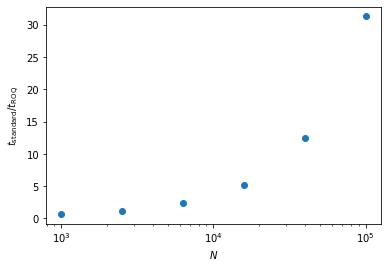

In [38]:
fig, ax = plt.subplots()
ax.semilogx(Ns, np.array(tstandard) / np.array(troq), 'o', ls="none")
ax.set_xlabel("$N$")
ax.set_ylabel(r"$t_{\rm{standard}} / t_{\rm{ROQ}}$");

Below is a plot of the difference between the value of the log-likelihoods when summing over all $N$ data point compared to that using the ROQ calculation. It can be seen that the log-likelihood values are very similar showing that the ROQ is a very good approximation.

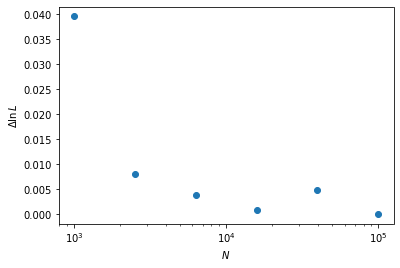

In [42]:
np.array(logLstandard) - np.array(logLroq)
fig, ax = plt.subplots()
ax.semilogx(Ns, np.abs(np.array(logLstandard) - np.array(logLroq)), 'o', ls="none")
ax.set_xlabel("$N$")
ax.set_ylabel(r"$\Delta \ln{L}$");

## Empirially calculating the reduced basis

I will now repeat the above analysis, but I will instead use the [Arby](https://arby.readthedocs.io/en/latest/index.html) package to empirically compute the set of basis vectors. To do this I need to generate a large array containing my model function evaluated over a wide range of the model parameters $\vec{\theta}$. This will be my "training" data. To do this I will need to define an explicit space in $\vec{\theta}$ over which to generate training vectors (in a Bayesian analysis this may be the prior probability volume). In this case I will generate training vectors by uniformly sampling random point from the parameter space between fixed ranges:

$$
\begin{array}{rcl}
A & \sim & \mathcal{U}(-10, 10), \\
\phi_0 & \sim & \mathcal{U}(0, 2\pi), \\
m & \sim & \mathcal{U}(-10, 10), \\
c & \sim & \mathcal{U}(-10, 10), \\
\end{array}
$$

where in this notation $\sim \mathcal{U}(x, y)$ means "draw a value from a uniform distribution between a lower bound of $x$ and an upper bound of $y$". In general, the set of basis vectors may not be valid when approxmating the original function outside of these training bounds, although in some cases they may still work outside the bounds.

Unlike in the previous [example](#A-simple-example), here I will generate a set of basis vectors for both the model and the square of the model.

In [61]:
from arby import reduced_basis

# generate training sets by drawing model parameters from across the prior
training = []

N = 10000  # number of points to evaluate the function
t = np.linspace(0, 10, N)

Ntraining = 10000
As = np.random.uniform(-10, 10, Ntraining)
phi0s = np.random.uniform(0, 2.0 * np.pi, Ntraining)
ms = np.random.uniform(-10, 10, Ntraining)
cs = np.random.uniform(-10, 10, Ntraining)

for pars in zip(As, phi0s, ms, cs):
    m = f(t, *pars)
    training.append(m)
    
# calculate reduced basis for the model
rb = reduced_basis(training_set=np.array(training), physical_points=t, greedy_tol=1e-12)
print(f"Number of reduced bases for the model: {len(rb.basis.data)}")

# calculate reduced basis for the squared model
rb2 = reduced_basis(
    training_set=np.array([m ** 2 for m in training]),
    physical_points=t,
    greedy_tol=1e-12
)
print(f"Number of reduced bases for the squared model: {len(rb2.basis.data)}")

Number of reduced bases for the model: 4
Number of reduced bases for the squared model: 9


To show the validity of these basis vectors, I'll calculate the coefficients for summing the basis vectors and plot these. 

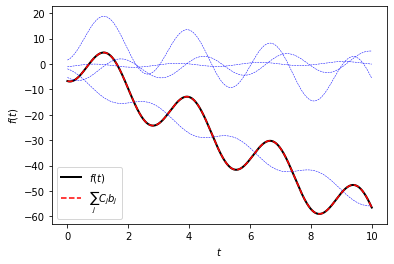

In [78]:
Ak = np.random.uniform(-10, 10)
phi0k = np.random.uniform(0, 2.0 * np.pi)
mk = np.random.uniform(-10, 10)
ck = np.random.uniform(-10, 10)

# evaluate the model
model = f(t, Ak, phi0k, mk, ck)

# calculate the B matrix
nbases = len(rb.basis.data)
indices = slice(0, -1, int(N / nbases) + 1)
B = np.array([row[indices] for row in rb.basis.data])

modelp = f(t[indices], Ak, phi0k, mk, ck)
C = np.dot(modelp, np.linalg.inv(B))

fig, ax = plt.subplots()
ax.plot(t, model, "k-", lw=2, label="$f(t)$")

rbmodel = np.zeros(rb.basis.data.shape[1])
for i in range(nbases):
    rbmodel += C[i] * rb.basis.data[i]
    ax.plot(t, C[i] * rb.basis.data[i], "b--", lw=0.5)
ax.plot(t, rbmodel, "r--", label="$\sum_j C_j b_j$")
    
ax.legend()
ax.set_xlabel("$t$");
ax.set_ylabel("$f(t)$");

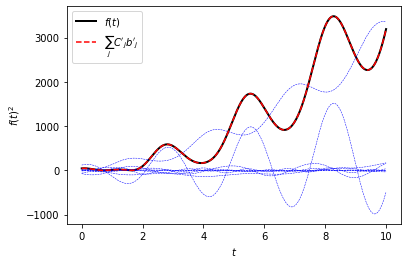

In [82]:
# evaluate the model-squared
model2 = model ** 2

# calculate the B matrix
nbases = len(rb2.basis.data)
indices = slice(0, -1, int(N / nbases) + 1)
Bp = np.array([row[indices] for row in rb2.basis.data])

modelp = f(t[indices], Ak, phi0k, mk, ck) ** 2
Cp = np.dot(modelp, np.linalg.inv(Bp))

fig, ax = plt.subplots()
ax.plot(t, model2, "k-", lw=2, label="$f(t)$")

rbmodel = np.zeros(rb2.basis.data.shape[1])
for i in range(nbases):
    rbmodel += Cp[i] * rb2.basis.data[i]
    ax.plot(t, Cp[i] * rb2.basis.data[i], "b--", lw=0.5)
ax.plot(t, rbmodel, "r--", label="$\sum_j C'_j b'_j$")

ax.legend()
ax.set_xlabel("$t$");
ax.set_ylabel("$f(t)^2$");

Now, I'll calculate the log-likelihood using the ROQ and compare it to that calculated by summing over all $N$ points.

In [84]:
# create the "data"
data = f(t, Ak, phi0k, mk, ck) + np.random.normal(sigma, N)

D = np.einsum("i,ji->j", data / sigma, rb.basis.data)
Bj = np.einsum("ji,ji->j", rb2.basis.data, rb2.basis.data)
K = np.sum((data / sigma) ** 2)

nbases = len(rb.basis.data)
indices = slice(0, -1, int(N / nbases) + 1)
B = np.array([row[indices] for row in rb.basis.data])
modelp = f(t[indices], Ak, phi0k, mk, ck) / sigma

nbases = len(rb2.basis.data)
indices = slice(0, -1, int(N / nbases) + 1)
Bp = np.array([row[indices] for row in rb2.basis.data])
modelp2 = (f(t[indices], Ak, phi0k, mk, ck) / sigma) ** 2

C = np.dot(modelp, np.linalg.inv(B))
Cp = np.dot(modelp2, np.linalg.inv(Bp))

logLroq = -0.5 * (K + np.sum(Cp * Bj) - 2 * np.sum(C * D))
logLstandard = -0.5 * (K + np.sum(model2 / sigma ** 2) - 2 * np.sum(model * data / sigma ** 2))

print(logLroq, logLstandard)

-146594415126.7171 -146594809506.98108


In [85]:
np.sum(Cp * Bj), np.sum(model2 / sigma ** 2)

(1087309.0422043405, 1876069.5701051338)

In [86]:
np.sum(model * data / sigma ** 2), np.sum(C * D)

(-615641780.3151962, -615641780.3151927)

## Appendix

To calculate the analytical integral for the squared model term in the [example](#A-simple-example)

$$
\int_{t_1}^{t_N} \left(A\sin{(2.3 t + \phi_0)} + mt + c\right)^2 {\rm d}t,
$$


I have used Sympy as below:

In [43]:
import sympy

# set variables
A, t, f, phi0, m, c, t0, tn = sympy.symbols("A t omega phi0 m c t0 tn")

# define function
func = (A * sympy.sin(f * t + phi0) + m * t + c) ** 2

# calculate definite integral
sympy.simplify(sympy.integrate(func, t)).args[0].args[0]

(12*A*m*sin(omega*t + phi0) - 3*A*omega*(A*sin(omega*t + phi0) + 4*c + 4*m*t)*cos(omega*t + phi0) + omega**2*t*(3*A**2 + 6*c**2 + 6*c*m*t + 2*m**2*t**2))/(6*omega**2)